In [1]:
import os

for i in os.walk('../'):
    print(i)

('../', ['src', 'lib', 'input', 'working'], [])
('../src', [], ['script.ipynb'])
('../lib', ['kaggle'], [])
('../lib/kaggle', [], ['gcp.py'])
('../input', ['entity-annotated-corpus'], [])
('../input/entity-annotated-corpus', [], ['ner.csv', 'ner_dataset.csv'])
('../working', [], ['__notebook__.ipynb'])


In [2]:
!pip install transformers==2.6.0

     |████████████████████████████████| 540 kB 3.2 MB/s 
  Attempting uninstall: transformers
    Found existing installation: transformers 2.8.0
    Uninstalling transformers-2.8.0:
      Successfully uninstalled transformers-2.8.0


In [3]:
import pandas as pd
import numpy as np
from tqdm import tqdm, trange

data = pd.read_csv("../input/entity-annotated-corpus/ner_dataset.csv", 
                   encoding="latin1").fillna(method="ffill")
data.tail().T

,1048570,1048571,1048572,1048573,1048574
Sentence #,Sentence: 47959,Sentence: 47959,Sentence: 47959,Sentence: 47959,Sentence: 47959
Word,they,responded,to,the,attack
POS,PRP,VBD,TO,DT,NN
Tag,O,O,O,O,O


In [4]:
class GetSentence(object):

    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [5]:
getter = GetSentence(data)

In [6]:
sentences = [[word[0] for word in sentence] for sentence in getter.sentences]
sentences[0]

['Thousands',
 'of',
 'demonstrators',
 'have',
 'marched',
 'through',
 'London',
 'to',
 'protest',
 'the',
 'war',
 'in',
 'Iraq',
 'and',
 'demand',
 'the',
 'withdrawal',
 'of',
 'British',
 'troops',
 'from',
 'that',
 'country',
 '.']

In [7]:
labels = [[s[2] for s in sentence] for sentence in getter.sentences]
labels[0]

['O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-geo',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-geo',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-gpe',
 'O',
 'O',
 'O',
 'O',
 'O']

In [8]:
tag_values = list(set(data["Tag"].values))
tag_values.append("PAD")
tag2idx = {t: i for i, t in enumerate(tag_values)}

tag2idx

{'I-tim': 0,
 'I-per': 1,
 'I-geo': 2,
 'I-gpe': 3,
 'I-eve': 4,
 'I-nat': 5,
 'B-eve': 6,
 'I-org': 7,
 'B-per': 8,
 'B-org': 9,
 'B-tim': 10,
 'O': 11,
 'I-art': 12,
 'B-art': 13,
 'B-gpe': 14,
 'B-geo': 15,
 'B-nat': 16,
 'PAD': 17}

In [9]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig

from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

torch.__version__

Using TensorFlow backend.


'1.4.0'

In [10]:
MAX_LEN = 75
bs = 32

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

In [12]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)

In [13]:
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count number of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels

In [14]:
tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(sentences, labels)
]

tokenized_texts_and_labels[-3:]

[(['Following',
   'Iran',
   "'",
   's',
   'disputed',
   'June',
   '12',
   'elections',
   ',',
   'rights',
   'groups',
   'said',
   'hundreds',
   'of',
   'people',
   'were',
   'detained',
   'in',
   'clashes',
   'with',
   'security',
   'forces',
   'during',
   'post',
   '-',
   'election',
   ',',
   'anti',
   '-',
   'government',
   'demonstrations',
   '.'],
  ['O',
   'B-geo',
   'O',
   'O',
   'O',
   'B-tim',
   'I-tim',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['Since',
   'then',
   ',',
   'authorities',
   'have',
   'held',
   'public',
   'trials',
   'of',
   'the',
   'accused',
   'and',
   'tried',
   'to',
   'marginal',
   '##ize',
   'moderate',
   'officials',
   'within',
   'the',
   'government',
   '.'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O

In [15]:
tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]

tokenized_texts[-3:]

[['Following',
  'Iran',
  "'",
  's',
  'disputed',
  'June',
  '12',
  'elections',
  ',',
  'rights',
  'groups',
  'said',
  'hundreds',
  'of',
  'people',
  'were',
  'detained',
  'in',
  'clashes',
  'with',
  'security',
  'forces',
  'during',
  'post',
  '-',
  'election',
  ',',
  'anti',
  '-',
  'government',
  'demonstrations',
  '.'],
 ['Since',
  'then',
  ',',
  'authorities',
  'have',
  'held',
  'public',
  'trials',
  'of',
  'the',
  'accused',
  'and',
  'tried',
  'to',
  'marginal',
  '##ize',
  'moderate',
  'officials',
  'within',
  'the',
  'government',
  '.'],
 ['The',
  'United',
  'Nations',
  'is',
  'praising',
  'the',
  'use',
  'of',
  'military',
  'helicopters',
  'to',
  'drop',
  'food',
  'and',
  'rescue',
  'survivors',
  'in',
  'tsunami',
  '-',
  'r',
  '##ava',
  '##ged',
  'Indonesia',
  ',',
  'saying',
  'the',
  'aircraft',
  'are',
  '"',
  'worth',
  'their',
  'weight',
  'in',
  'gold',
  '.',
  '"']]

In [16]:
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]

labels[-3:]

[['O',
  'B-geo',
  'O',
  'O',
  'O',
  'B-tim',
  'I-tim',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O'],
 ['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O'],
 ['O',
  'B-org',
  'I-org',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-tim',
  'B-tim',
  'B-tim',
  'B-tim',
  'B-tim',
  'I-tim',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O']]

In [17]:
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN,
                          dtype="long",
                          value=0.0,
                          truncating="post",
                          padding="post")
input_ids[-3:]

array([[ 2485,  3398,   112,   188, 11807,  1340,  1367,  3212,   117,
         2266,  2114,  1163,  5229,  1104,  1234,  1127, 15474,  1107,
        19708,  1114,  2699,  2088,  1219,  2112,   118,  1728,   117,
         2848,   118,  1433, 14476,   119,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0],
       [ 1967,  1173,   117,  3912,  1138,  1316,  1470,  7356,  1104,
         1103,  4806,  1105,  1793,  1106, 16404,  3708,  8828,  3878,
         1439,  1103,  1433,   119,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     

In [18]:
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, 
                     value=tag2idx["PAD"],
                     padding="post",
                     dtype="long", 
                     truncating="post")
tags[-3:]

array([[11, 15, 11, 11, 11, 10,  0, 11, 11, 11, 11, 11, 11, 11, 11, 11,
        11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
        17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
        17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
        17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17],
       [11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
        11, 11, 11, 11, 11, 11, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
        17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
        17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
        17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17],
       [11,  9,  7, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
        11, 10, 10, 10, 10, 10,  0, 11, 11, 11, 11, 11, 11, 11, 11, 11,
        11, 11, 11, 11, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
        17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
        17, 17, 17, 17, 17, 17

In [19]:
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]
attention_masks[-3:]

[[1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 [1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0

In [20]:
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, 
                                                            tags,
                                                            random_state=0,
                                                            test_size=0.1)
tr_masks, val_masks, _, _ = train_test_split(attention_masks,
                                             input_ids,
                                             random_state=0,
                                             test_size=0.1)

In [21]:
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

In [22]:
train_data = TensorDataset(tr_inputs,
                           tr_masks,
                           tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data,
                              sampler=train_sampler, 
                              batch_size=bs)

valid_data = TensorDataset(val_inputs,
                           val_masks, 
                           val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data,
                              sampler=valid_sampler,
                              batch_size=bs)

In [23]:
import transformers
from transformers import BertForTokenClassification, AdamW

In [24]:
model = BertForTokenClassification.from_pretrained(
    "bert-base-cased",
    num_labels=len(tag2idx),
    output_attentions = False,
    output_hidden_states = False
)

In [25]:
model.cuda()

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [26]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    
    param_optimizer = list(model.named_parameters())
    
    no_decay = ['bias', 'gamma', 'beta']
    
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=4e-5,
    eps=1e-8
)


In [27]:
from transformers import get_linear_schedule_with_warmup

epochs = 3
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

In [28]:
!pip install seqeval
from seqeval.metrics import f1_score

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=2).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


  Created wheel for seqeval: filename=seqeval-0.0.12-py3-none-any.whl size=7423 sha256=4ab6dea8b469e8b71a114c3312789b989a89ab5384d5d78f6a966894d0b527ff
  Stored in directory: /root/.cache/pip/wheels/dc/cc/62/a3b81f92d35a80e39eb9b2a9d8b31abac54c02b21b2d466edc
Successfully built seqeval


In [29]:
# Store the average loss after each epoch so we can plot them.
loss_values, validation_loss_values = [], []

for _ in trange(epochs, desc="Epoch"):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    # Put the model into training mode.
    model.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):
        
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        
        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()
        
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = model(b_input_ids, 
                        token_type_ids=None,
                        attention_mask=b_input_mask, 
                        labels=b_labels)
        
        # get the loss
        loss = outputs[0]
        
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        
        # track train loss
        total_loss += loss.item()
        
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), 
                                       max_norm=max_grad_norm)
        
        # update parameters
        optimizer.step()
        
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print(f'Average train loss: {avg_train_loss}')

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # Put the model into evaluation mode
    model.eval()
    
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = model(b_input_ids, 
                            token_type_ids=None,
                            attention_mask=b_input_mask, 
                            labels=b_labels)
        
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        eval_accuracy += flat_accuracy(logits, label_ids)
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

        nb_eval_examples += b_input_ids.size(0)
        nb_eval_steps += 1

    eval_loss = eval_loss / nb_eval_steps
    validation_loss_values.append(eval_loss)
    print(f'Validation loss: {eval_loss}')
    print(f'Validation Accuracy: {eval_accuracy / nb_eval_steps}')
    
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    valid_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]
    print(f'Validation F1-Score: {f1_score(pred_tags, valid_tags)}')

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Average train loss: 0.18376399051975195
Validation loss: 0.12678207064668337
Validation Accuracy: 0.32173373015872997


Epoch:  33%|███▎      | 1/3 [06:30<13:01, 390.66s/it]

Validation F1-Score: 0.8199504561657904
Average train loss: 0.10400687668022401
Validation loss: 0.12303298843403657
Validation Accuracy: 0.32228055555555546


Epoch:  67%|██████▋   | 2/3 [12:59<06:30, 390.21s/it]

Validation F1-Score: 0.8301004347174337
Average train loss: 0.0726171428057399
Validation loss: 0.12925301785270374
Validation Accuracy: 0.3225357142857141


Epoch: 100%|██████████| 3/3 [19:28<00:00, 389.43s/it]

Validation F1-Score: 0.835119315623593


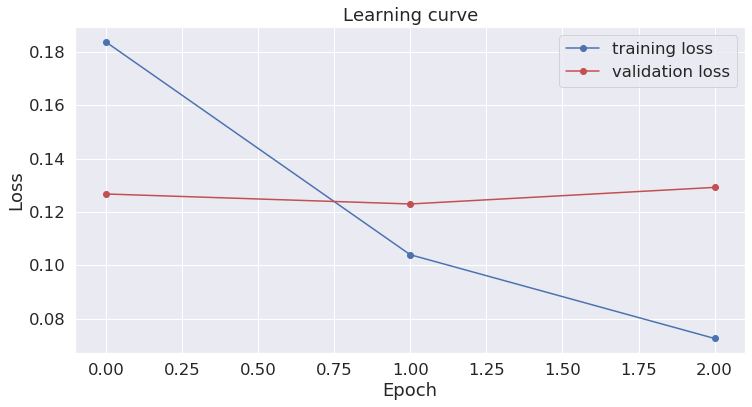

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [31]:
test_sentence = """
Prime Minister Narendra Modi holds a detailed meeting to discuss financial sector, 
structural and welfare measures to spur growth in Maharashtra, Delhi, Karnataka, Tamilnadu 
"""


In [32]:
tokenized_sentence = tokenizer.encode(test_sentence)
input_ids = torch.tensor([tokenized_sentence]).cuda()

In [33]:
with torch.no_grad():
    output = model(input_ids)
label_indices = np.argmax(output[0].to('cpu').numpy(),
                          axis=2)

In [34]:
# join bpe split tokens
tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
new_tokens, new_labels = [], []

for token, label_idx in zip(tokens, label_indices[0]):
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(tag_values[label_idx])
        new_tokens.append(token)


In [35]:
for token, label in zip(new_tokens, new_labels):
    print(f'{label}  {token}')

O  [CLS]
B-per  Prime
I-per  Minister
B-per  Narendra
I-per  Modi
O  holds
O  a
O  detailed
O  meeting
O  to
O  discuss
O  financial
O  sector
O  ,
O  structural
O  and
O  welfare
O  measures
O  to
O  spur
O  growth
O  in
B-geo  Maharashtra
O  ,
B-geo  Delhi
O  ,
B-geo  Karnataka
O  ,
B-geo  Tamilnadu
O  [SEP]
